In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
import util
import plot.viz_sequence as viz_sequence
from feature.util import one_hot_to_seq
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
tf_names = [
    "E2F6", "FOXA2", "SPI1", "CEBPB", "MAX", "GABPA", "MAFK", "JUND", "NR3C1-reddytime", "REST"
]

tf_num_tasks = {
    "E2F6": 2,
    "FOXA2": 4,
    "SPI1": 4,
    "CEBPB": 7,
    "MAX": 7,
    "GABPA": 9,
    "MAFK": 9,
    "JUND": 14,
    "NR3C1-reddytime": 16,
    "REST": 20
}

tf_best_model_types = {
    "E2F6": list("MM"),
    "FOXA2": list("SSMM"),
    "SPI1": list("MSSS"),
    "CEBPB": list("MMMMSMM"),
    "MAX": list("MMSMMSS"),
    "GABPA": list("MMMSMMMMM"),
    "MAFK": list("MMMMMMMMM"),
    "JUND": list("SMMSMSSSSSSSMS"),
    "NR3C1-reddytime": list("MMMSMMSMMMMSMMMM"),
    "REST": list("MMMMMMMMMSMMSMMSMMMM")
}

### Helper functions

In [4]:
def get_motif_hits_path(tf_name, model_type, task_index, hit_type):
    """
    Gets the path to the cached results for _profile_ head, using
    the given TF name, the model type ("S" or "M"), and a task index.
    """
    assert model_type in ("M", "S")
    assert hit_type in ("tfm", "moods")
    
    path_match = lambda path: path.startswith(tf_name + "_") and "task%d_" % task_index in path and path.endswith("_profile")
    
    base_dir = "/users/amtseng/tfmodisco/results/reports/motif_hits/cache/%s" % hit_type
    subdir = os.path.join(base_dir, "multitask_profile_finetune" if model_type == "M" else "singletask_profile_finetune")
    results_dir = [
        path for path, _, _ in os.walk(subdir) if path_match(os.path.basename(path))
    ]
    assert len(results_dir) == 1
    return results_dir[0]

In [5]:
def get_tfmodisco_results_path(tf_name, model_type, task_index):
    """
    Gets the path to the cached results for _profile_ head, using
    the given TF name, the model type ("S" or "M"), and a task index.
    """
    assert model_type in ("M", "S")
    
    name_match = lambda name: name.startswith(tf_name + "_") and "task%d_" % task_index in name and name.endswith("_profile_tfm.h5")
    
    base_dir = "/users/amtseng/tfmodisco/results/tfmodisco"
    subdir = os.path.join(base_dir, "multitask_profile_finetune" if model_type == "M" else "singletask_profile_finetune")
    
    results_path = None
    for path, _, names in os.walk(subdir):
        for name in names:
            if name_match(name):
                assert results_path is None
                results_path = os.path.join(path, name)
    return results_path

In [6]:
def import_motif_hits(tf_name, model_type, task_index, hit_type):
    """
    From the given TF name, the model type ("S" or "M"), and a task
    index, imports the set of filtered motif hits, from the _profile_
    head. Uses the hit type specified.
    """
    results_dir = get_motif_hits_path(tf_name, model_type, task_index, hit_type)
    hits_path = os.path.join(results_dir, "filtered_hits.tsv")
    return pd.read_csv(hits_path, sep="\t", header=0, index_col=False)

In [7]:
def import_motif_hits_per_peak(tf_name, model_type, task_index, hit_type):
    """
    From the given TF name, the model type ("S" or "M"), and a task
    index, imports the set of number of motif hits per peak, from
    the _profile_ head. Uses the hit type specified.
    """
    results_dir = get_motif_hits_path(tf_name, model_type, task_index, hit_type)
    peak_matched_hits_path = os.path.join(results_dir, "peak_matched_hits.tsv")
    num_hits_per_peak = []
    with open(peak_matched_hits_path, "r") as f:
        next(f)  # Header
        for line in f:
            tokens = line.split("\t")
            if not tokens[1].strip():
                num_hits_per_peak.append(0)
            else:
                num_hits_per_peak.append(tokens[1].count(",") + 1)
    return np.array(num_hits_per_peak)

In [8]:
def import_all_motif_hits_per_peak(hit_type, keys=None):
    """
    Imports all motif hit counts for all TFs and tasks, for the
    given hit type. If specified, limits to given keys.
    Returns a dictionary mapping tuple (TF name, task index) to arrays of
    hits per peak.
    """
    if not keys:
        keys = [
            (tf_name, task_index) for tf_name in tf_names for task_index in range(tf_num_tasks[tf_name])
        ]
    result = {}
    for key in tqdm.notebook.tqdm(keys):
        tf_name, task_index = key
        model_type = tf_best_model_types[tf_name][task_index]
        result[key] = import_motif_hits_per_peak(tf_name, model_type, task_index, hit_type)
    return result

In [9]:
def import_motif_hits_per_pattern(tf_name, model_type, task_index, hit_type):
    """
    From the given TF name, the model type ("S" or "M"), and a task
    index, imports the set of number of motif hits per pattern, from
    the _profile_ head. Uses the hit type specified.
    """
    results_dir = get_motif_hits_path(tf_name, model_type, task_index, hit_type)
    motif_hits = import_motif_hits(tf_name, model_type, task_index, hit_type)
    num_hits_per_pattern = {}
    for key in np.unique(motif_hits["key"]):
        num_hits_per_pattern[key] = len(motif_hits[motif_hits["key"] == key])
    return num_hits_per_pattern

In [10]:
def import_all_motif_hits_per_pattern(hit_type, keys=None):
    """
    Imports all motif hit counts for all TFs and tasks, for the
    given hit type. If specified, limits to given keys.
    Returns a dictionary mapping tuple (TF name, task index) to dictionaries of
    hits per motif key.
    """
    if not keys:
        keys = [
            (tf_name, task_index) for tf_name in tf_names for task_index in range(tf_num_tasks[tf_name])
        ]
    result = {}
    for key in tqdm.notebook.tqdm(keys):
        tf_name, task_index = key
        model_type = tf_best_model_types[tf_name][task_index]
        result[key] = import_motif_hits_per_pattern(tf_name, model_type, task_index, hit_type)
    return result

In [11]:
def import_seqlets_per_pattern(tf_name, model_type, task_index):
    """
    From the given TF name, the model type ("S" or "M"), and a task
    index, imports the set of number of seqlets per pattern, from
    the _profile_ head.
    """
    tfm_results_path = get_tfmodisco_results_path(tf_name, model_type, task_index)
    num_seqlets_per_pattern = {}

    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"].keys():
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                seqlets = pattern["seqlets_and_alnmts"]["seqlets"]
                
                motif_key = "%s_%s" % (metacluster_key.split("_")[1], pattern_name.split("_")[1])
                num_seqlets_per_pattern[motif_key] = len(seqlets)
    return num_seqlets_per_pattern

In [12]:
def import_all_seqlets_per_pattern(keys=None):
    """
    Imports all pattern seqlet counts for all TFs and tasks.
    If specified, limits to given keys.
    Returns a dictionary mapping tuple (TF name, task index) to
    dictionaries of seqlet counts per motif key.
    """
    if not keys:
        keys = [
            (tf_name, task_index) for tf_name in tf_names for task_index in range(tf_num_tasks[tf_name])
        ]
    result = {}
    for key in tqdm.notebook.tqdm(keys):
        tf_name, task_index = key
        model_type = tf_best_model_types[tf_name][task_index]
        result[key] = import_seqlets_per_pattern(tf_name, model_type, task_index)
    return result

### Import and plot motif hit stats

In [13]:
cond_keys = [
    (tf_name, task_index) for tf_name in tf_names for task_index in range(tf_num_tasks[tf_name])
]

hits_per_peak = import_all_motif_hits_per_peak("tfm")
hit_counts = import_all_motif_hits_per_pattern("tfm")
seqlet_counts = import_all_seqlets_per_pattern()

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

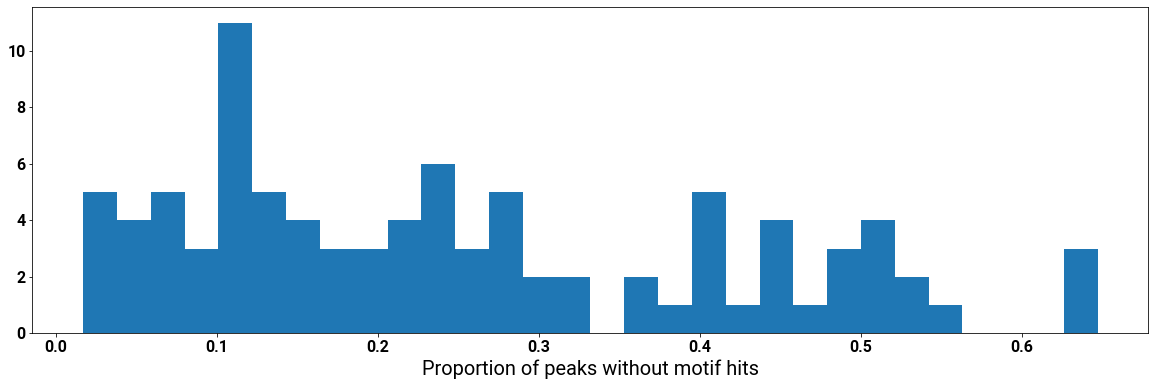

('GABPA', 1) 0.5196891735797543
('JUND', 1) 0.5067617227693665
('JUND', 12) 0.5036782520593807
('REST', 4) 0.539676220806794
('REST', 7) 0.5171068838100452
('REST', 8) 0.6469264479450433
('REST', 10) 0.5573003263747768
('REST', 14) 0.5346240301646001
('REST', 17) 0.6405046120455778
('REST', 19) 0.6318698347107438


In [14]:
# Proportion of peaks without hits
keys = hits_per_peak.keys()
prop_peaks_without_hits = [
    np.sum(hits_per_peak[key] == 0) / len(hits_per_peak[key]) for key in keys
]

fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(prop_peaks_without_hits, bins=30)
ax.set_xlabel("Proportion of peaks without motif hits")
plt.show()

for key, prop in zip(keys, prop_peaks_without_hits):
    if prop > 0.5:
        print(key, prop)

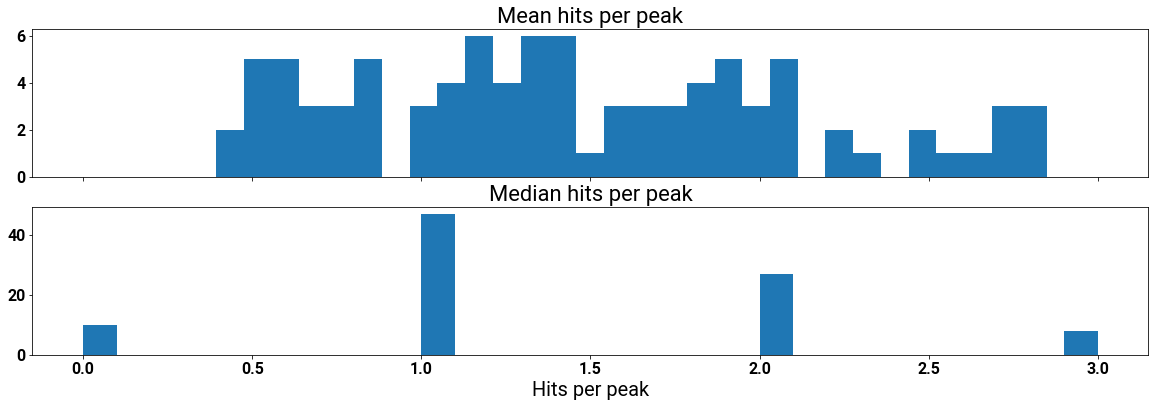

('GABPA', 1) 0.0
('JUND', 1) 0.0
('JUND', 12) 0.0
('REST', 4) 0.0
('REST', 7) 0.0
('REST', 8) 0.0
('REST', 10) 0.0
('REST', 14) 0.0
('REST', 17) 0.0
('REST', 19) 0.0


In [15]:
# Mean and median number of hits per peak
# Proportion of peaks without hits
keys = hits_per_peak.keys()
mean_hits_per_peak = [
    np.mean(hits_per_peak[key]) for key in keys
]
median_hits_per_peak = [
    np.median(hits_per_peak[key]) for key in keys
]

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 6))
ax[0].hist(mean_hits_per_peak, bins=30)
ax[0].set_title("Mean hits per peak")
ax[1].hist(median_hits_per_peak, bins=30)
ax[1].set_title("Median hits per peak")
ax[1].set_xlabel("Hits per peak")
plt.show()

for key, val in zip(keys, median_hits_per_peak):
    if val == 0:
        print(key, val)

('GABPA', 0) 0_3 0.34432760760237735 0.030911658559548093
('GABPA', 3) 0_2 0.5021568989955013 0.17061698791847274
('GABPA', 4) 0_0 0.9161335349540537 0.5963581183611533
('MAFK', 7) 0_0 0.25802147613121734 0.6055137549964731
('MAFK', 7) 0_1 0.6102608182482969 0.3087820362097343
('JUND', 1) 0_2 0.5515187611673615 0.1422027899229648
('JUND', 2) 0_2 0.48443700396825395 0.11253298153034301
('JUND', 5) 0_0 0.9330584060611873 0.609800111049417
('REST', 9) 0_0 0.11444992268868337 0.512600162582743
('REST', 9) 0_2 0.666977856871955 0.09034955289745675
('REST', 13) 0_1 0.4695168226663294 0.15841313269493845
('REST', 16) 0_3 0.47589143161255987 0.04767751176590956


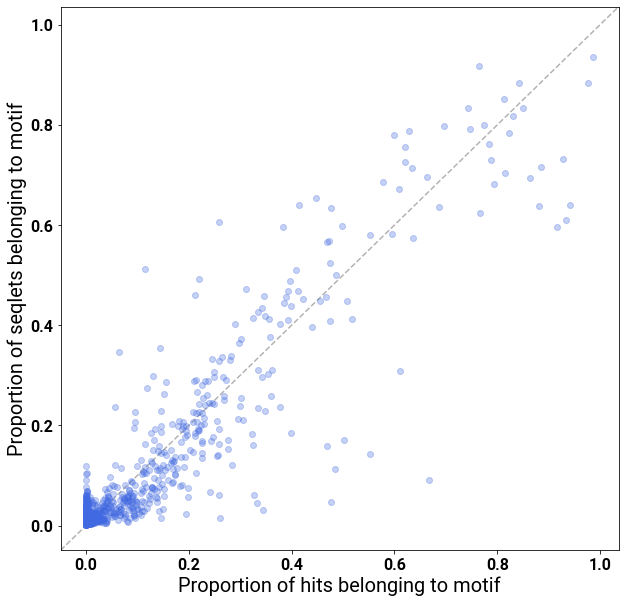

In [16]:
# Difference between number of hits per motif and number of seqlets per motif

norm_dict = lambda d: {k : d[k] / np.sum(list(d.values())) for k in d}

fig, ax = plt.subplots(figsize=(10, 10))
for key in hit_counts.keys():
    hit_counts_dict = norm_dict(hit_counts[key])
    seqlet_counts_dict = norm_dict(seqlet_counts[key])
    
    motif_keys = list(hit_counts_dict.keys())
    hc = np.array([hit_counts_dict[k] for k in motif_keys])
    sc = np.array([seqlet_counts_dict[k] for k in motif_keys])
    ax.scatter(hc, sc, alpha=0.3, color="royalblue")
    
    too_diff = np.where(np.abs(hc - sc) > 0.3)[0]
    if too_diff.size:
        for i in too_diff:
            print(key, motif_keys[i], hc[i], sc[i])

ax.set_xlabel("Proportion of hits belonging to motif")
ax.set_ylabel("Proportion of seqlets belonging to motif")
(min_x, max_x), (min_y, max_y) = ax.get_xlim(), ax.get_ylim()
min_both, max_both = min(min_x, min_y), max(max_x, max_y)
ax.set_xlim(min_both, max_both)
ax.set_ylim(min_both, max_both)
ax.plot(
    [min_both, max_both], [min_both, max_both],
    color="black", linestyle="--", alpha=0.3, zorder=0
)
plt.show()